# This is the initial version of the pipeline. The current version is
[GeneratorBehavioralCloning.ipynb](https://github.com/autohandle/CarNDBehavioralCloningP3/blob/master/GeneratorBehavioralCloning.ipynb)


In [2]:
import csv

DATADIRECTORY="./simData"
IMAGEDIRECTORY="./simData/IMG"
DRIVINGLOG=DATADIRECTORY+"/driving_log.csv"
lines=[]
with open(DRIVINGLOG) as csvFile:
    reader=csv.reader(csvFile)
    for line in reader:
        lines.append(line)

import cv2

CENTERIMAGE=0
STEERINGMEASUEMENT=3
CAMERAS=3
# CENTER, LEFT, RIGHT
STERRINGADJUSTMENT=[0, .3, -.3]


In [3]:
images=[]
steeringMeasurements=[]
for line in lines:
#for line in lines[0:1]:
    for camera in range(CAMERAS):
        imagePathOnRemote=line[camera]
        filename=imagePathOnRemote.split("/")[-1]
        imagePath=IMAGEDIRECTORY+"/"+filename
        image=cv2.imread(imagePath)
        if (image==None):
            print ("line:", line)
            print("image:", image, ", imagePath:", imagePath)
            exit
        #print("imagePath:", imagePath, "image.shape:", image.shape)
        images.append(image)
        steeringMeasurements.append(float(line[STEERINGMEASUEMENT])+STERRINGADJUSTMENT[camera])
    #print("line:", line)
    #print("len(images):", len(images), "steeringMeasurements:", steeringMeasurements)

print("len(images):", len(images), "len(steeringMeasurements):", len(steeringMeasurements))
print("images[0].shape:", images[0].shape)
assert len(images)==len(steeringMeasurements)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # Remove the CWD from sys.path while we load stuff.


len(images): 32511 len(steeringMeasurements): 32511
images[0].shape: (160, 320, 3)


In [ ]:
import cv2

images=[]
steeringMeasurements=[]
for line in lines:
#for line in lines[0:1]:
    for camera in range(CAMERAS):
        imagePathOnRemote=line[camera]
        filename=imagePathOnRemote.split("/")[-1]
        imagePath=IMAGEDIRECTORY+"/"+filename
        image=cv2.imread(imagePath)
        if (image==None):
            print ("line:", line)
            print("image:", image, ", imagePath:", imagePath)
            exit
        #print("imagePath:", imagePath, "image.shape:", image.shape)
        images.append(image)
        steering=float(line[STEERINGMEASUEMENT])+STERRINGADJUSTMENT[camera]
        steeringMeasurements.append(steering)
        images.append(cv2.flip(image,1))
        steeringMeasurements.append(steering*-1)
    #print("line:", line)
    #print("len(images):", len(images), "steeringMeasurements:", steeringMeasurements)

print("len(images):", len(images), "len(steeringMeasurements):", len(steeringMeasurements))
print("images[0].shape:", images[0].shape)
assert len(images)==len(steeringMeasurements)


In [ ]:
grayScaleImages=[]
grayScaleSteering=[]
for image, steering in zip(augmentedImages, augmentedSteering):
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    grayScaleImage=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayScaleImages.append(grayScaleImage)
    grayScaleSteering.append(steering)


In [4]:
import numpy as np

X_train=np.array(images)
y_train=np.array(steeringMeasurements)

#X_train=np.array(grayScaleImages)
#y_train=np.array(grayScaleSteering)

print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print("X_train[0].shape:", X_train[0].shape)

X_train.shape: (32511, 160, 320, 3) y_train.shape: (32511,)
X_train[0].shape: (160, 320, 3)


In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import keras as keras

XtrainInputShape=X_train.shape[1:len(X_train.shape)]
print ("XtrainInputShape:", XtrainInputShape)

model = Sequential()
#model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=XtrainInputShape))

model.add(Cropping2D(cropping=((70,25),(0,0))))

#model.add(Flatten(input_shape=X_train.shape[1:4]))
#model.add(Flatten(input_shape=(160,320,3)))

# add lenet
#model.add(Convolution2D(10, 5, 5, input_shape=XtrainInputShape, activation="relu"))
#model.add(MaxPooling2D())
#model.add(Convolution2D(6, 5, 5, activation="relu"))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dropout(.25))
#model.add(Dense(120))
#model.add(Dropout(.25))
#model.add(Dense(84))

# nvidia model
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

##
model.add(Dense(1))

#from keras import Optimizers

adamOptimizer=keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adamOptimizer, loss='mse', metrics=['accuracy'])
history_object=model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=4)

import datetime

modelFilename=datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")+".model"
print ("saving model as:", modelFilename)
model.save(modelFilename)

XtrainInputShape: (160, 320, 3)
Train on 26008 samples, validate on 6503 samples
Epoch 1/4
26008/26008 [==============================] - 61s - loss: 0.0318 - acc: 0.2364 - val_loss: 0.0557 - val_acc: 0.2482
Epoch 2/4
26008/26008 [==============================] - 58s - loss: 0.0240 - acc: 0.2365 - val_loss: 0.0487 - val_acc: 0.2483
Epoch 3/4
26008/26008 [==============================] - 58s - loss: 0.0213 - acc: 0.2365 - val_loss: 0.0582 - val_acc: 0.2483
Epoch 4/4
26008/26008 [==============================] - 58s - loss: 0.0191 - acc: 0.2365 - val_loss: 0.0568 - val_acc: 0.2477
dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])
saving model as: 2017_07_11_20_44.model


dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


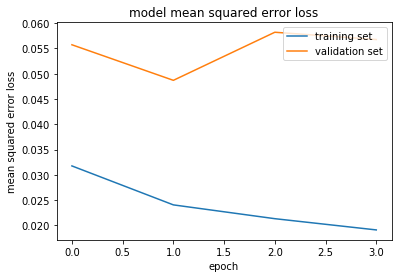

In [7]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()